# Collaborative Filtering - Page Rank

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
%matplotlib inline

## Load datas

In [3]:
from data.get_data import GetData

In [4]:
data = GetData()

The GetData class will load all the given files (candidate_items.csv, item_features.csv, test_final_sessions.csv, test_leaderboard_sessions.csv, train_purchases.csv and train_sessions.csv) and store it in the data object.

The given file dressipi_recsys2022.zip should be present in the data folder !

## Page Rank

We now load our python file and create the PageRank objet.

In [5]:
from functions.page_rank import PageRank

In [6]:
page_rank = PageRank(data.df_train_purchases["item_id"].unique().tolist())
# The argument is data.df_train_purchases["item_id"].unique().tolist() because we want to recommend items
# that should be recommended by the algorithm (because they are in the solution).
# This is done because we have the PageRank.list_candidate_items list that contain the list of items that
# should be recommended for the leaderboard datas.

The adjaceny matrix used by Page Rank is used to simulate the activity of a user for a current item. Each item has associated the probability for the user to see/buy this item.

We thus have two options to construct this adjaceny matrix :
- Represent the activity of the client by adding 1 when a client goes from one item to another
- Represent the item that will be bought the client

### Adjaceny matrix v1: the Client's activity (item seen to next item seen or purchased item)

In this version, we represent the client's activity.

In [7]:
page_rank.create_adjacency_matrix(data.df_item_features, data.train_sessions, data.train_purchases, mode="session_to_session_purchase", g=1)

C:\Users\User\Desktop\SCIA\SYMA\project\SYMA\functions\page_rank.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["item_next"][:-1] = df["item_id"][1:]


..........adj_matrix done


In [8]:
page_rank.process_page_rank(data.test_sessions, n_iter=1, validate_to_use=data.test_purchases)

array created
.1 iterations done
.........................................add session [0:4096]
array created
.1 iterations done
.........................................add session [4096:8192]
array created
.1 iterations done
...................add session [8192:10000]
Score: 0.006748798380595939


In [9]:
page_rank.process_page_rank(data.test_sessions, n_iter=2, validate_to_use=data.test_purchases)

array created
..2 iterations done
.........................................add session [0:4096]
array created
..2 iterations done
.........................................add session [4096:8192]
array created
..2 iterations done
...................add session [8192:10000]
Score: 0.00911453754519569


In [10]:
page_rank.process_page_rank(data.test_sessions, n_iter=4, validate_to_use=data.test_purchases)

array created
....4 iterations done
.........................................add session [0:4096]
array created
....4 iterations done
.........................................add session [4096:8192]
array created
....4 iterations done
...................add session [8192:10000]
Score: 0.011104750316119336


In [11]:
page_rank.process_page_rank(data.test_sessions, n_iter=6, validate_to_use=data.test_purchases)

array created
......6 iterations done
.........................................add session [0:4096]
array created
......6 iterations done
.........................................add session [4096:8192]
array created
......6 iterations done
...................add session [8192:10000]
Score: 0.011192925927140586


We can see the score of the predictions is better when we use more iterations. However the score remains very low: 0.011 with 6 iterations.

Because of the low score and the time to compute predictions, we will not use this version.

### Adjaceny matrix v2: the item that will buy the client (item seen to purchased item)

In this version, we represent the item that the client will buy

In [12]:
page_rank.create_adjacency_matrix(data.df_item_features, data.train_sessions, data.train_purchases, mode="session_to_purchase", g=1)

..............................adj_matrix done


In [13]:
page_rank.process_page_rank(data.test_sessions, n_iter=1, validate_to_use=data.test_purchases)

array created
.1 iterations done
.........................................add session [0:4096]
array created
.1 iterations done
.........................................add session [4096:8192]
array created
.1 iterations done
...................add session [8192:10000]
Score: 0.1779188012335783


The score is 0.178 !!!!!!!!

In [14]:
page_rank.process_page_rank(data.test_sessions, n_iter=2, validate_to_use=data.test_purchases)

array created
..2 iterations done
.........................................add session [0:4096]
array created
..2 iterations done
.........................................add session [4096:8192]
array created
..2 iterations done
...................add session [8192:10000]
Score: 0.1054174218611992


In [15]:
page_rank.process_page_rank(data.test_sessions, n_iter=4, validate_to_use=data.test_purchases)

array created
....4 iterations done
.........................................add session [0:4096]
array created
....4 iterations done
.........................................add session [4096:8192]
array created
....4 iterations done
...................add session [8192:10000]
Score: 0.060063757550701244


We can see that page rank with one iteration is better because the predictions are going too far from the items seen. Moreover, after multiple tests, we saw that taking more "last seen items" into account is more efficient with a multiplicator of 31/30 (default value of multi_last_better parameter).

So, when we'll use page rank, we'll only use one iteration and we'll take more "last seen items" into account.

### Visualisation

We plot the result to have more information on our results.

In [16]:
page_rank.process_page_rank(data.test_sessions, n_iter=1, validate_to_use=data.test_purchases)

array created
.1 iterations done
.........................................add session [0:4096]
array created
.1 iterations done
.........................................add session [4096:8192]
array created
.1 iterations done
...................add session [8192:10000]
Score: 0.1779188012335783


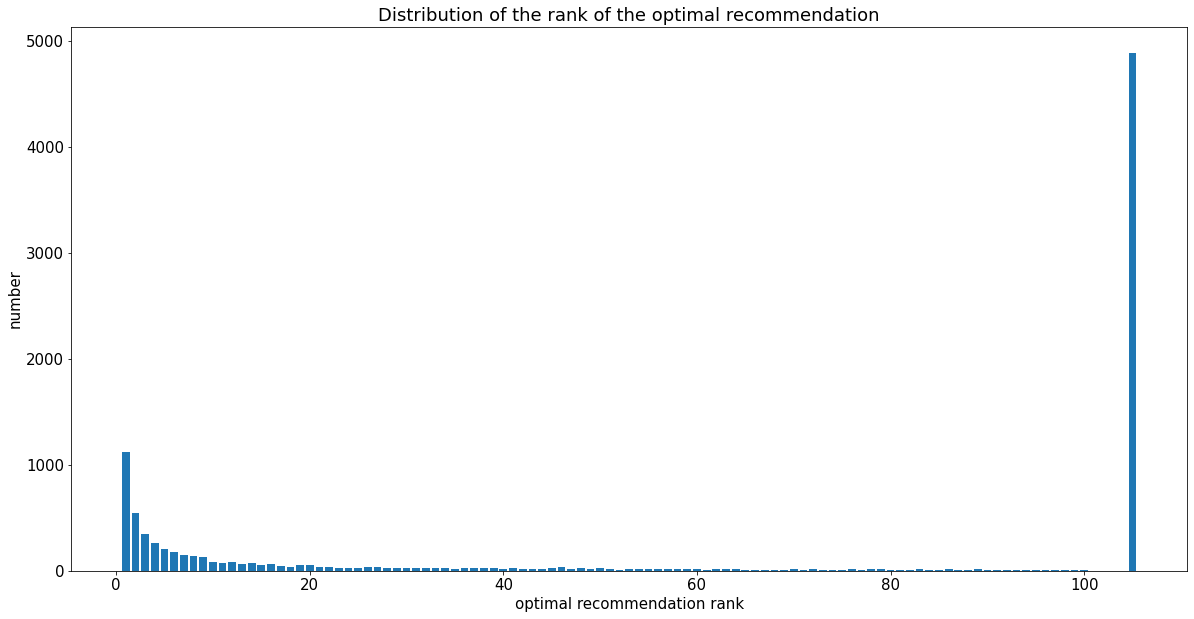

In [17]:
page_rank.show_distrib_rank()

105 is the number used to plot the predictions that are not in the top 100.

We can see that our result of 0.178 is not due to an overall good prediction but a good prediction for a subset of the sessions ! In Particular, more than 48% of the sessions have very bad predictions (optimal prediction is not in the top 100) !!!

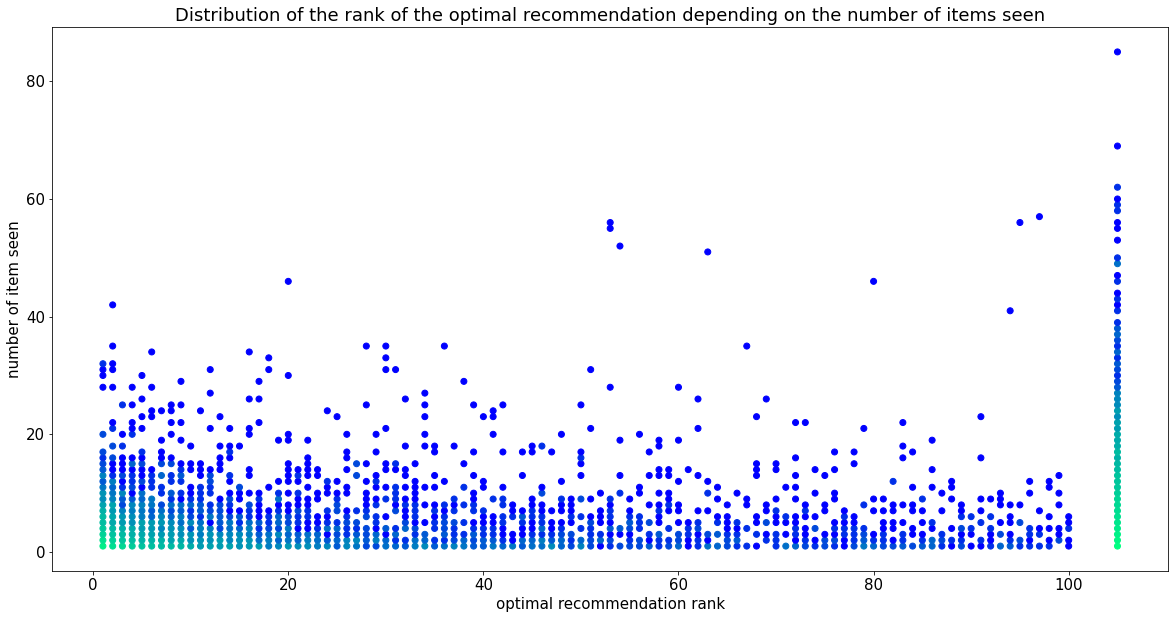

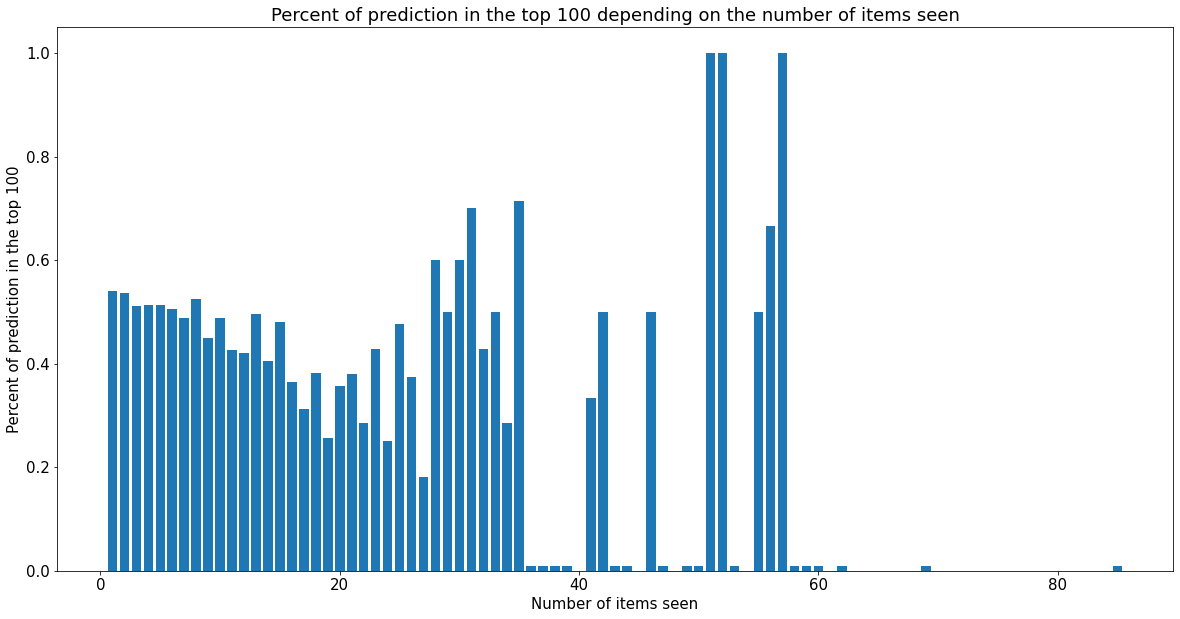

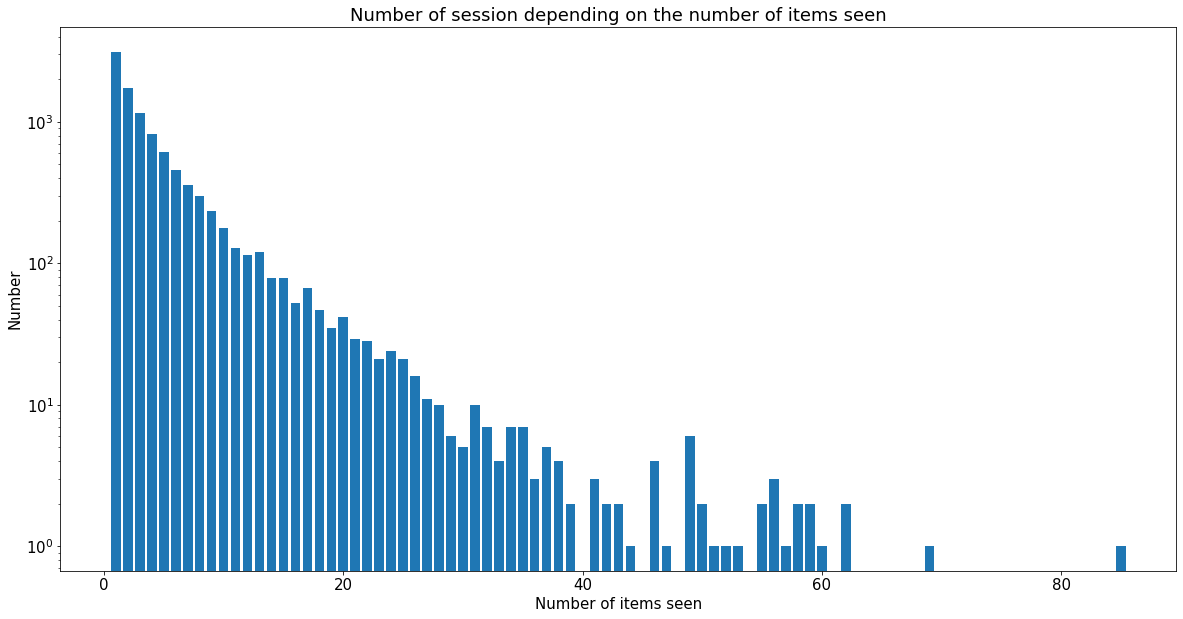

In [18]:
page_rank.show_stat_bad_sessions(data.test_sessions)

We can see that our alghoritm is not horrible when we have few seen items in the seesion ! Although, our results are not excelent when we have more seen items in the session.

## Create result for leaderboard

This final section is used to create the csv file containing the predictions for the leaderboard data.

In [19]:
page_rank = PageRank(data.list_candidate_items)

In [20]:
page_rank.create_adjacency_matrix(data.df_item_features, data.df_train_sessions, data.df_train_purchases, mode="session_to_purchase", g=1, leader = True)

..............................adj_matrix done


In [21]:
page_rank.process_page_rank(data.df_test_leaderboard_sessions, n_iter=1, save=True)

array created
.1 iterations done
.........................................add session [0:4096]
array created
.1 iterations done
.........................................add session [4096:8192]
array created
.1 iterations done
.........................................add session [8192:12288]
array created
.1 iterations done
.........................................add session [12288:16384]
array created
.1 iterations done
.........................................add session [16384:20480]
array created
.1 iterations done
.........................................add session [20480:24576]
array created
.1 iterations done
.........................................add session [24576:28672]
array created
.1 iterations done
.........................................add session [28672:32768]
array created
.1 iterations done
.........................................add session [32768:36864]
array created
.1 iterations done
.........................................add session [36864:40960]
array cr